# Лабораторная работа №2 (вариант №4)

##Задание

В рамках данной лабораторной работы предполагается построение бинарного классификатора с помощью полносвязной нейронной сети
Задание
1. Выберите предметную область
2. Спроектируйте полносвязную нейронную сеть с использованием Python и TensorFlow

Написать программу на языке Python, выполняющую построение и обучение нейронных сетей прямого распространения, решающих задачу бинарной классификации по вариантам, требуется подобрать безызбыточную архитектуру сети, работающей с допустимым уровнем ошибки и визуализировать процесс обучения моделей. Результаты работы привести в отчете.

Построение бинарного классификатора. Написать программу на Python, которая обучает нейросетевой регрессор, с помощью библиотек scikit-learn и keras (опционально PyTorch). Датасет – Яблоко и Апельсин. (https://www.tensorflow.org/datasets/catalog/cycle_gan)

##Импорт библиотек

In [ ]:
!pip install scikit-learn

In [1]:
import sklearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# библиотеки для работы с директориями
import pathlib
from pathlib import Path
import os
import natsort
import shutil

# библиотеки для работы с изображениями
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# модуль для предварительной обработки изображений
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# импорт слоев нейросети
from keras import layers
from keras.layers.experimental import preprocessing
# импорт модели
from keras.models import Sequential
from keras.optimizers import RMSprop

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
!pip install -q kaggle

In [ ]:
!pip install split-folders

import splitfolders

In [ ]:
# подключение диска

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Нейронные сети/Lab_2/"

In [ ]:
from keras.models import load_model
from keras.preprocessing import image

## Функции

In [ ]:
# Функция для визуализации процесса обучения

def history_visualization(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.legend()
  plt.show()

In [ ]:
# Функция для оценки моделей классификации

def compute_metrics(model, x_test, y_test, y_predicted, y_predicted_prob):
  print("\n Accuracy Score : \n ",accuracy_score(y_test,y_predicted))
  print("\n AUC Score : \n", roc_auc_score(y_test, y_predicted_prob))
  print("\n Confusion Matrix : \n ",confusion_matrix(y_test, y_predicted))
  print("\n Classification Report : \n",classification_report(y_test, y_predicted))

In [ ]:
# Функция для оценки моделей классификации

def compute_evaluation_metric(true_classes, predicted_classes):
  print("\n Accuracy Score : \n ",accuracy_score(true_classes,predicted_classes))
  print("\n AUC Score : \n", roc_auc_score(true_classes, predicted_classes))
  print("\n Confusion Matrix : \n ",confusion_matrix(true_classes, predicted_classes))
  print("\n Classification Report : \n",classification_report(true_classes, predicted_classes))

In [ ]:
# функция, которая создает директорию

def make_dir(path):

  # проверка директории на существование
  if os.path.exists(path) == False:
    os.mkdir(path)

# функция, которая копирует файлы из папки folder_from в папку folder_to

def copy_files(folder_from, folder_to):
  for f in os.listdir(folder_from):
    if os.path.isfile(os.path.join(folder_from, f)):
        shutil.copy(os.path.join(folder_from, f), os.path.join(folder_to, f))

In [ ]:
# функция, которая выводит изображения на экран
# path - директория с изображениями, images_list - список названий,
# ind_from - индекс изображения, с которого нужно выводить на экран,
# ind_to - индекс изображения, до которого нужно отображать,
# cols - количество столбцов

def display_images(path, images_list, ind_from, ind_to, cols):

  # создаем график(фигуру) для вывода всех фото
  pic_box = plt.figure(figsize=(14,12))

  image_count = ind_to - ind_from
  rows = image_count // cols

  if (image_count % rows != 0):
    rows = rows + 1

  for i, image_name in enumerate(images_list[ind_from:ind_to]):

      # считываем текущее изображение
      image = plt.imread(str(Path(path, image_name)))

      # создаем "подграфик" для вывода текущего изображения в заданной позиции
      ax = pic_box.add_subplot(rows,cols,i+1)
      pic_box.tight_layout (h_pad = 1)

      # в качестве названия графика определяем имя фотографии и число каналов
      ax.set_title(str(image_name) + '\n Каналов = ' + str(image.shape[2]))

      # выводим изображение на экран
      plt.imshow(image)

      # отключаем вывод осей графика
      plt.axis('off')

  plt.show()

In [ ]:
# конвертирование фото из RGB в RGBA (альфа-канал)
def convert_rgb_to_rgba(path, img):
  im = Image.open(Path(path,img))

  # если расширение файла ".png" и формат файла "PNG":
  if (img[-3:].lower()=='png' and im.format == 'PNG'):

      # если режим изображения не RGBA (без альфа-канала):
      if im.mode != 'RGBA':

          # конвертируем фото в RGBA и сохраняем в той же директории под тем же именем
          im.convert("RGBA").save(Path(path, img))

          # выводим имена файлов, которые были переформатированы
          print(img)

In [ ]:
def about_images(path, images_list):


  for i, image_name in enumerate(images_list):

      # считываем текущее изображение
      image = plt.imread(str(Path(path, image_name)))
      #print(image.shape)
      im = Image.open(str(Path(path, image_name)))
      pix = np.array(im)
      #print(im.size)
      print(pix.shape)



In [ ]:
def generate_image_prediction(model, image_path):

  img = image.load_img(image_path, target_size=(256,256))
  x = image.img_to_array(img)
  img_test = np.expand_dims(x, axis=0)

  classes = model.predict(img_test)


  return classes.astype(int)

In [ ]:
def set_of_images_predictions(model, path, filenames):

  pred_classes_list = []

  for name in filenames:
    image_path = str(Path(path, name))
    classes = generate_image_prediction(model, image_path)
    pred_classes_list.append(classes)

  pred_classes_arr = np.array(pred_classes_list)

  return pred_classes_arr.reshape(len(filenames))

In [ ]:
def get_evaluation(model, test_data, test_path):
  true_classes = test_data.classes
  class_labels = list(test_data.class_indices.keys())

  part_test_oranges_path = test_path + '/oranges'

  part_test_path_oranges_filenames = os.listdir(part_test_oranges_path)
  part_test_path_oranges_filenames  = natsort.natsorted(part_test_path_oranges_filenames)

  part_test_apples_path = test_path + '/apples'

  part_test_path_apples_filenames = os.listdir(part_test_apples_path)
  part_test_path_apples_filenames = natsort.natsorted(part_test_path_apples_filenames)

  a = set_of_images_predictions(model, part_test_apples_path, part_test_path_apples_filenames)
  o = set_of_images_predictions(model, part_test_oranges_path, part_test_path_oranges_filenames)

  predictions = np.concatenate((a, o), axis=None)

  report = sklearn.metrics.classification_report(true_classes, predictions, target_names=class_labels)
  print(report)


  print("\n Confusion Matrix : \n ",confusion_matrix(true_classes, predictions))

##Апельсины и грейпфруты (пример)

###Cчитывание и просмотр набора данных

In [ ]:
df = pd.read_csv(path + 'citrus.csv')
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


###Подготовка данных

Проверка, что данный набор данных не содержит пропущенных значений и выбросов

In [ ]:
df.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


Проверка сбалансированности классов

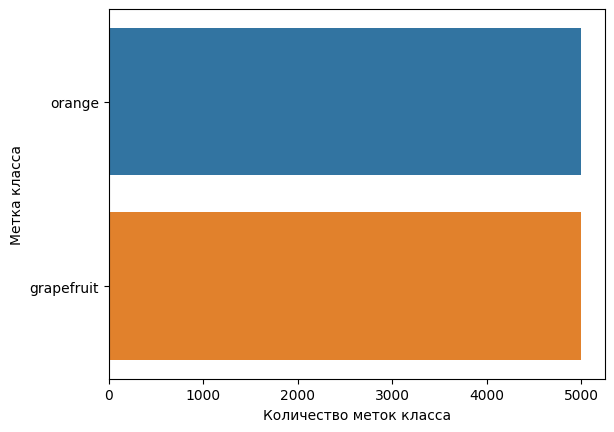

In [ ]:
sns.countplot(y=df['name'] ,data=df)
plt.xlabel("Количество меток класса")
plt.ylabel("Метка класса")
plt.show()

Кодирование меток целевого класса цифрами: 1 — это апельсин, 0 — это грейпфрут

In [ ]:
le = LabelEncoder()
df['name'] = le.fit_transform(df['name'])

Проверка правильности кодирования

In [ ]:
le.inverse_transform(df['name'])

array(['orange', 'orange', 'orange', ..., 'grapefruit', 'grapefruit',
       'grapefruit'], dtype=object)

Разбиение всей выборки на обучающую и тестовую, на обучающей выборке будет обучаться модель, на тестовой будет проводится оценка

In [ ]:
X = df.drop(['name'],axis=1).values
y = df['name'].values
# Split the dataset into the training set and test set
X_train,X_test,y_train,y_test=train_test_split(X, y,
test_size = 0.2,
random_state = 0)

Стандартизация

In [ ]:
# Scale X dataset
scaler=StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

###Модель полносвязной нейронной сети с использованием фреймворка Keras

В качестве модели предлагается использовать модель с тремя полносвязными слоями. Первому слою должна передаваться форма входных данных. Используйте функции
3
активации для первого и второго слоя relu. Функция активации выходного слоя должна возвращать вероятность принадлежности экземпляра целевому классу.

In [ ]:
model = keras.Sequential([
layers.Dense(16, input_dim=X_train.shape[1], activation="relu"),
layers.Dense(16, activation="relu"),
layers.Dense(1, activation="sigmoid")
])

Настройка процесса обучения. Задаем оптимизатор и функция(-и) потерь, которые должны использоваться моделью, а также все метрики для мониторинга во время обучения

In [ ]:
model.compile(optimizer="adam",
loss="binary_crossentropy",
metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 16)                96        
                                                                 
 dense_23 (Dense)            (None, 16)                272       
                                                                 
 dense_24 (Dense)            (None, 1)                 17        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###Обучение модели

Обучение модели происходит на 20 эпохах, 20 процентов обучающей выборки будет использовано для оценки модели, во время обучения, размер пакета 32. Можно изменить количество эпох обучения на более высокое значение, однако это займет значительно больше времени.

In [ ]:
history = model.fit(X_train,
y_train,
epochs=20,
batch_size=32,
validation_split=0.2)

Epoch 1/20
200/200 [==============================] - 1s 3ms/step - loss: 0.4174 - accuracy: 0.8281 - val_loss: 0.2149 - val_accuracy: 0.9262
Epoch 2/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1859 - accuracy: 0.9284 - val_loss: 0.1902 - val_accuracy: 0.9269
Epoch 3/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1768 - accuracy: 0.9292 - val_loss: 0.1893 - val_accuracy: 0.9250
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.9295 - val_loss: 0.1879 - val_accuracy: 0.9287
Epoch 5/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1731 - accuracy: 0.9308 - val_loss: 0.1872 - val_accuracy: 0.9287
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9322 - val_loss: 0.1865 - val_accuracy: 0.9281
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9319 - val_loss: 0.1862 - val_accuracy: 0.9306
Epoch 

После строим предсказания и визуализируем их. Строим график для визуализации изменения оценки модели на разных эпохах. Когда наступает переобучение?

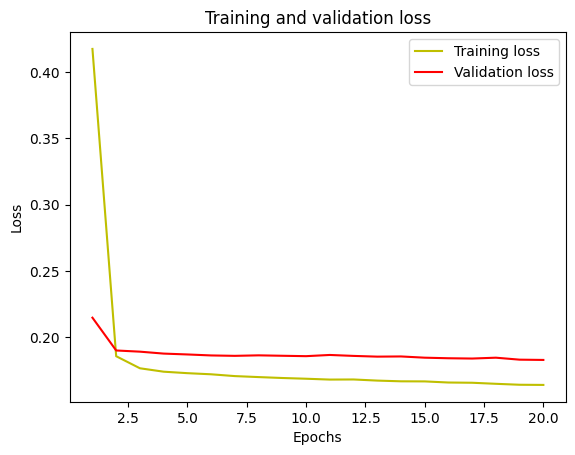

In [ ]:
history_visualization(history)

###Оценка модели

Функция для оценки модели

In [ ]:
y_predicted_prob = model.predict(X_test)
y_predicted = (y_predicted_prob > 0.5).astype(int)
compute_metrics(model, X_test, y_test, y_predicted, y_predicted_prob)

63/63 [==============================] - 0s 2ms/step

 Accuracy Score : 
  0.917

 AUC Score : 
 0.9795970619769246

 Confusion Matrix : 
  [[934  78]
 [ 88 900]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      1012
           1       0.92      0.91      0.92       988

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.1843 - accuracy: 0.9170


[0.18433719873428345, 0.9169999957084656]

##Яблоки и апельсины (по вариантам)

###Cчитывание и просмотр набора данных

Загрузка данных с Kaggle с помощью API


In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"komarish","key":"65e2561e1a22ee2690cd6685b6102bd7"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/apple2orange-dataset

apple2orange-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Распаковываем архив

In [ ]:
!unzip "/content/apple2orange-dataset.zip" -d "/content/apple2orange-dataset"

Archive:  /content/apple2orange-dataset.zip
replace /content/apple2orange-dataset/metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

В скачанном датасете изображения заранее разделены на две папки с обучающей выборкой и две папки с тестовой. Такое разделение показалось мне неудобным, поэтому я создала папки "apples" и "oranges", чтобы в последующем с помощью функции splitfolders.ratio самостоятельно разделить изображения на обучающую, валидационную и тестовую выборки.

Копируем все яблоки и апельсины в новые папки.

In [ ]:
trainA_path = "/content/apple2orange-dataset/trainA/"
trainB_path = "/content/apple2orange-dataset/trainB/"

testA_path = "/content/apple2orange-dataset/testA/"
testB_path = "/content/apple2orange-dataset/testB/"

In [ ]:
dataset_path = "/content/dataset/"

apples_path = "/content/dataset/apples/"
oranges_path = "/content/dataset/oranges/"

In [ ]:
# создали директорию dataset, в ней папки apples и oranges

make_dir(dataset_path)
make_dir(apples_path)
make_dir(oranges_path)

In [ ]:
# копировали файлы в созданные папки

copy_files(trainA_path, apples_path)
copy_files(testA_path, apples_path)

copy_files(trainB_path, oranges_path)
copy_files(testB_path, oranges_path)

In [ ]:
# Получим и отсортируем список с названиями фото яблок

apples_path_filenames = os.listdir(apples_path)
apples_path_filenames = natsort.natsorted(apples_path_filenames)

In [ ]:
# Получим и отсортируем список с названиями фото апельсинов

oranges_path_filenames = os.listdir(oranges_path)
oranges_path_filenames = natsort.natsorted(oranges_path_filenames)

Выведем изображения на экран.

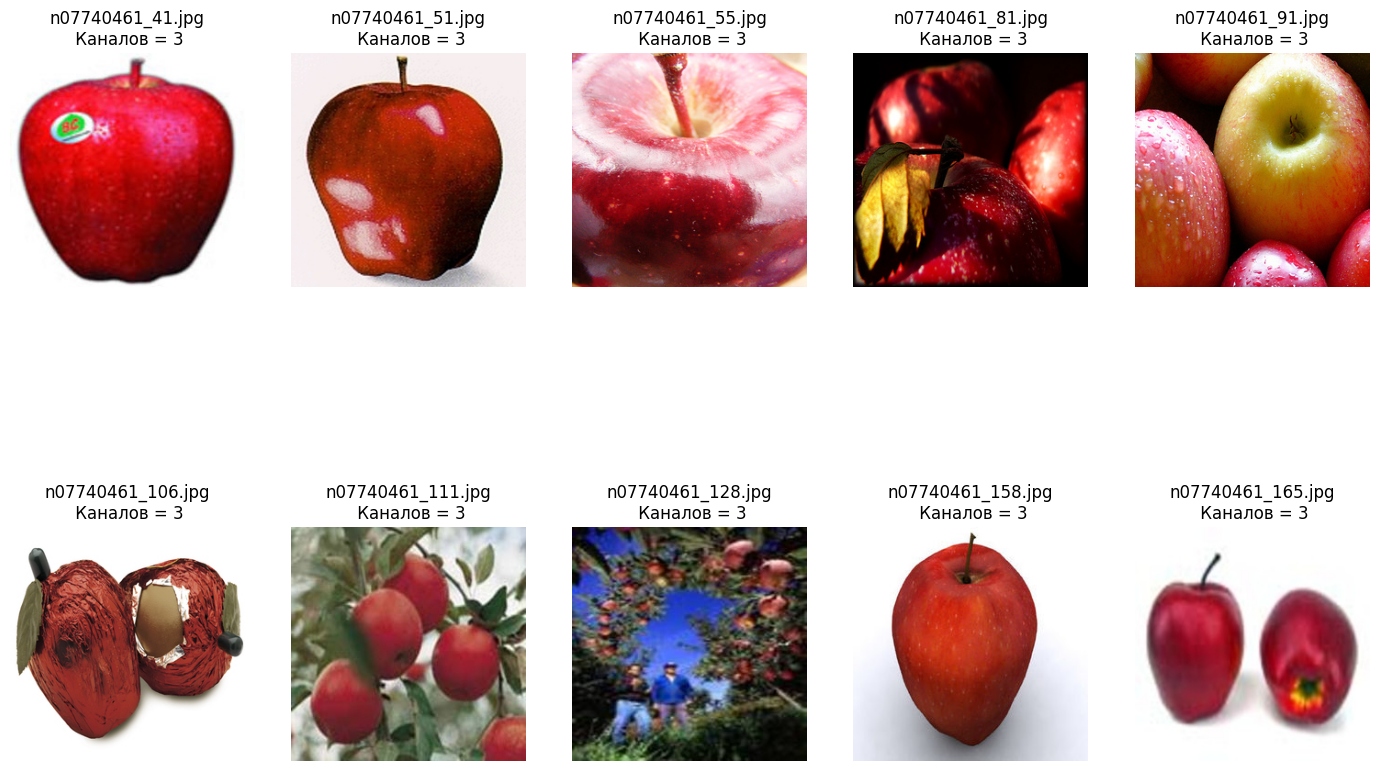

In [ ]:
# выведем яблоки с 5 по 15 картинки в 5 столбцов
display_images(apples_path, apples_path_filenames, 5, 15, 5)

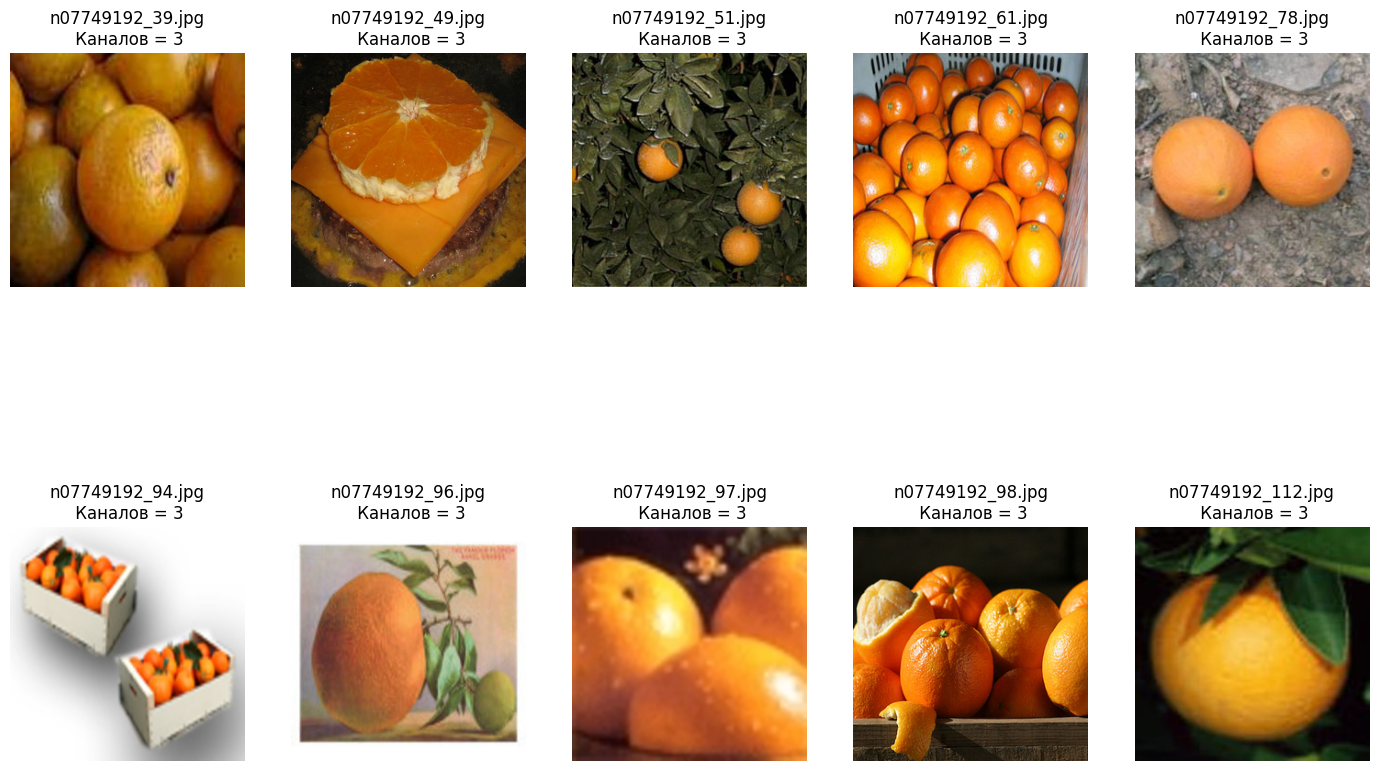

In [ ]:
# выведем апельсины с 5 по 15 картинки в 5 столбцов
display_images(oranges_path, oranges_path_filenames, 5, 15, 5)

###Подготовка данных

Подготавливаем изображения в формате png, чтобы не было проблем с обработкой изображений без альфа-канала.

In [ ]:
for img in apples_path_filenames:
  convert_rgb_to_rgba(apples_path, img)

In [ ]:
for img in oranges_path_filenames:
  convert_rgb_to_rgba(oranges_path, img)

Проверка датасета на сбалансированность

<BarContainer object of 2 artists>

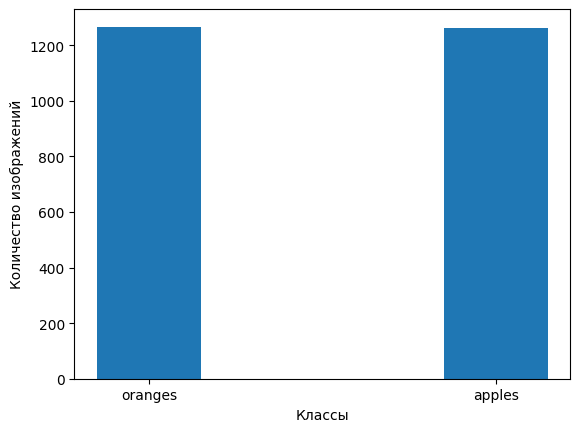

In [ ]:
values = [len(oranges_path_filenames), len(apples_path_filenames)]
labels = ['oranges', 'apples']

plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.bar(x=labels, height=values, width = 0.3)

Разделение данных на тренировочную, валидационную и тестовую выборки. Получаем папки images_splited, в которой содержатся папки train, val и test.

In [ ]:
splited_path = "images_splited"

In [ ]:
splitfolders.ratio(dataset_path, splited_path, ratio=(0.8, 0.15, 0.05), seed=18, group_prefix=None )

Copying files: 2528 files [00:02, 1081.71 files/s]


Нормализация данных

Поскольку изображения заданы в формате RGB, то каждый пиксель кодируется тройкой чисел в диапазоне от 0 до 255. Масштабируем значения, чтобы каждое число было в диапазоне от 0 до 1.

In [ ]:
train_path = splited_path + "/train"
val_path = splited_path + "/val"

In [ ]:
# определим параметры нормализации данных
train = ImageDataGenerator(rescale=1/255)
val = ImageDataGenerator(rescale=1/255)

# сгенерируем нормализованные данные
train_data = train.flow_from_directory(train_path, target_size=(256,256),
                          class_mode='binary', shuffle=True)
val_data = val.flow_from_directory(val_path, target_size=(256,256),
                                  class_mode='binary', shuffle=True)


Found 2021 images belonging to 2 classes.
Found 379 images belonging to 2 classes.


In [ ]:
test_path = splited_path + "/test"

In [ ]:
# определим параметры нормализации данных
test = ImageDataGenerator(rescale=1/255)

# сгенерируем нормализованные данные
test_data = test.flow_from_directory(test_path, target_size=(256,256),
                          class_mode='binary')

Found 128 images belonging to 2 classes.


###Модель нейронной сети

В качестве модели была использована модель с тремя полносвязными слоями и слоем Flatten, расположенным на модели первым. Flatten используется для конвертации входящих данных в меньшую размерность. В нашем случае трехмерный массив-изображение конвертируется в одномерный массив для более удобной обработки данных. Слой Flatten позволяет осуществить данное преобразование, объединяя элементы вложенных массивов в один единый массив.


Функциями активации внутренних слоёв являются relu. Функция активации выходного слоя должна возвращать вероятность принадлежности экземпляра целевому классу, в данной модели была использована sigmoid для бинарной классификации.

In [ ]:
basic_model = Sequential([
  tf.keras.layers.Flatten(input_shape=(256,256,3)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Файл для сохранения модели с лучшими параметрами
basic_model_checkpoint_filepath = 'best_model_basic'

Настройка процесса обучения модели.

В качестве оптимизатора был выбран adam как наиболее эффективный алгоритм оптимизации, сочетающий в себе идеи RMSProp и оптимизатора импульса. Выбранная функция потерь бианрная кросс-энтропия - это вариант функции потери кросс-энтропии, которая используется для задач бинарной классификации. Она измеряет разницу между предсказанной вероятностью положительного класса и истинной меткой. Также указываем метрику accuracy для оценки модели.

In [ ]:
basic_model.compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = ["accuracy"]
)

basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 32)                6291488   
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6292033 (24.00 MB)
Trainable params: 6292033 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Настраиваем функцию-callback, позволяющую отслеживать метрики в процессе обучения модели и сохранять модель с лучшими настройками.

In [ ]:
basic_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath = basic_model_checkpoint_filepath,
  monitor = 'val_accuracy',
  mode = 'max',
  save_best_only = True
)

NameError: ignored

###Обучение модели

Обучение модели производилось на 32 эпохах с размером батча, равным 32.

In [ ]:
# Обучение модели
basic_model_history = basic_model.fit(
    train_data,
    batch_size = 32,
    verbose = 1,
    epochs = 32,
    validation_data = val_data,
    callbacks = [basic_model_checkpoint_callback]
  )

NameError: ignored

###Оценка модели

Визуализируем процесс обучения модели.

По графику можно отметить, что после 15 эпохи кривые потерь начинают "расходиться", что говорит о переобучнии.

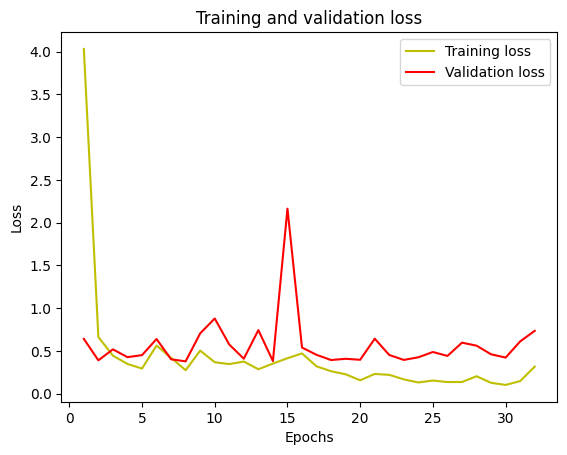

In [ ]:
history_visualization(basic_model_history)

Загрузим из файла модель, показавшую наилучшие рещультаты во время обучения.

In [ ]:
basic_model_loaded = keras.models.load_model(basic_model_checkpoint_filepath)

Оценим модель на тестовой выборке.

**Значение точности на тестовой выборке составило 0.81.**

In [ ]:
basic_model_loaded.evaluate(test_data)

4/4 [==============================] - 1s 107ms/step - loss: 0.5395 - accuracy: 0.8125


[0.5395424365997314, 0.8125]

In [ ]:
get_evaluation(basic_model_loaded, test_data, test_path)

1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

      apples       0.81      0.80      0.80        64
     oranges       0.80      0.81      0.81        64

    accuracy                           0.80       128
   macro avg       0.80      0.80      0.80       128
weighted avg       0.80      0.80      0.80       128


 Confusion Matrix : 
  [[51 13]
 [12 52]]


##Повышение точности

Попробуем повысить точность модели несколькими способами.

###Оптимизатор RMSprop

Заменим оптимизатор adam на оптимизатор RMSprop.

Такой выбор позволяет учитывать историю градиентов, но при этом размер шага уменьшается не так быстро. Проблема с градиентами в том, что некоторые из них маленькие, а другие – огромны. Таким образом, определение единой скорости обучения может быть не лучшей идеей. RMSProp адаптирует размер шага индивидуально для каждого веса. В этом алгоритме два градиента сначала сравниваются по знакам. Если они имеют одинаковый знак, мы идем в правильном направлении и, следовательно, увеличиваем размер шага на небольшую долю. Если же они имеют противоположные знаки, мы должны уменьшить размер шага. Затем мы ограничиваем размер шага, и теперь мы можем перейти к обновлению веса.

####Модель нейронной сети

Модель нейронной сети и прочие параметры остаются прежними.

In [ ]:
opt_basic_model = Sequential([
  tf.keras.layers.Flatten(input_shape=(256,256,3)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Файл для сохранения модели с лучшими параметрами
opt_basic_model_checkpoint_filepath = 'best_model_opt_basic'

In [ ]:
opt_basic_model.compile(
  optimizer = "RMSprop",
  loss = "binary_crossentropy",
  metrics = ["accuracy"]
)

basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 32)                6291488   
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6292033 (24.00 MB)
Trainable params: 6292033 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt_basic_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath = opt_basic_model_checkpoint_filepath,
  monitor = 'val_accuracy',
  mode = 'max',
  save_best_only = True
)

####Обучение модели

In [ ]:
# Обучение модели
opt_basic_model_history = opt_basic_model.fit(
    train_data,
    batch_size = 32,
    verbose = 1,
    epochs = 32,
    validation_data = val_data,
    callbacks = [opt_basic_model_checkpoint_callback]
  )

Epoch 1/32
64/64 [==============================] - 17s 252ms/step - loss: 8.2669 - accuracy: 0.5136 - val_loss: 0.6990 - val_accuracy: 0.5040
Epoch 2/32
64/64 [==============================] - 10s 155ms/step - loss: 0.9523 - accuracy: 0.5166 - val_loss: 0.6758 - val_accuracy: 0.6385
Epoch 3/32
64/64 [==============================] - 10s 156ms/step - loss: 0.6336 - accuracy: 0.6739 - val_loss: 0.5806 - val_accuracy: 0.7573
Epoch 4/32
64/64 [==============================] - 11s 177ms/step - loss: 0.5725 - accuracy: 0.7417 - val_loss: 0.5953 - val_accuracy: 0.7177
Epoch 5/32
64/64 [==============================] - 9s 145ms/step - loss: 0.5265 - accuracy: 0.7853 - val_loss: 0.5235 - val_accuracy: 0.8074
Epoch 6/32
64/64 [==============================] - 11s 174ms/step - loss: 0.4886 - accuracy: 0.8006 - val_loss: 0.4662 - val_accuracy: 0.8417
Epoch 7/32
64/64 [==============================] - 12s 180ms/step - loss: 0.4648 - accuracy: 0.8110 - val_loss: 0.4317 - val_accuracy: 0.8443


####Оценка модели

Визуализируем процесс обучения.

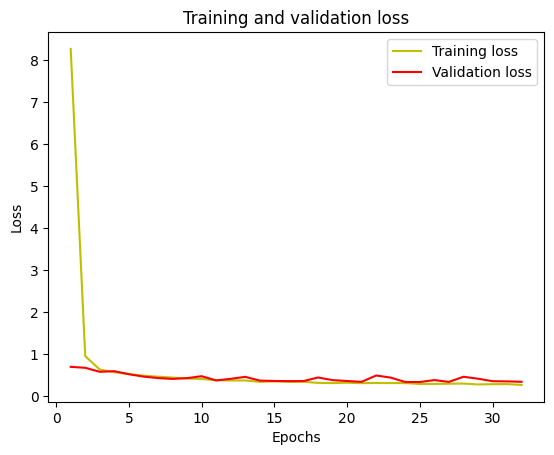

In [ ]:
history_visualization(opt_basic_model_history)

Загрузим из файла модель с наилучшими параметрами и оценим её.

In [ ]:
opt_basic_model_loaded = keras.models.load_model(opt_basic_model_checkpoint_filepath)

Оценим модель на тестовой выборке.

**Значение точности на тестовой выборке составило 0.84.**

Таким образом можно заключить, что параметр оптимизации RMSprop оказался лучше для данной задачи по сравнению с adam.

In [ ]:
opt_basic_model_loaded.evaluate(test_data)

4/4 [==============================] - 1s 80ms/step - loss: 0.3847 - accuracy: 0.8438


[0.3846992254257202, 0.84375]

In [ ]:
get_evaluation(opt_basic_model_loaded, test_data, test_path)

###Аугментация

Оставим оптимизатор RMSprop и добавим аугментацию.

Чем больше входных данных передается нейросети, тем лучше результат обучения. Для улучшения результата во время обучения сети будем генерировать новые данные за счет незначительных преобразований имеющихся фотографий - отражение по горизонтали, незначительные наклоны фото, изменение контраста и размера.

In [ ]:
# определяем параметры аугментации

data_augmentation = keras.Sequential(
  [
    # отражение по горизонтали
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(256, 256,3)),

    # вращение на рандомное значение до 0.05
    layers.experimental.preprocessing.RandomRotation(0.05),

    # меняем контрастность изображений
    layers.experimental.preprocessing.RandomContrast(0.23),

    # изменяем размер
    layers.experimental.preprocessing.RandomZoom(0.2)

  ]
)

####Модель нейронной сети

Создаем модель с аугментацией.

In [ ]:
aug_model = Sequential([
  # добавили аугментацию
  data_augmentation,
  tf.keras.layers.Flatten(input_shape=(256,256,3)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
# Файл для сохранения модели с лучшими параметрами
aug_model_checkpoint_filepath = 'best_model_aug'

Компилируем модель с параметром RMSprop.

In [ ]:
aug_model.compile(
  optimizer="RMSprop",
  loss="binary_crossentropy",
  metrics=["accuracy"]
)

aug_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 flatten_4 (Flatten)         (None, 196608)            0         
                                                                 
 dense_12 (Dense)            (None, 32)                6291488   
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6292033 (24.00 MB)
Trainable params: 6292033 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
aug_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=aug_model_checkpoint_filepath,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)


####Обучение модели

Обучение модели производилось на 40 эпохах с размером батча равным 1 (пакеты (батчи) размером 32 и 10 дали худшие результаты по сравнению с этим значением).

In [ ]:
# Обучение модели
aug_model_history = aug_model.fit(
  train_data,
  batch_size=1,
  verbose=1,
  epochs= 40,
  validation_data=val_data,
  callbacks=[aug_model_checkpoint_callback]
)


Epoch 1/40
64/64 [==============================] - 39s 577ms/step - loss: 1.1147 - accuracy: 0.7308 - val_loss: 0.4207 - val_accuracy: 0.8232
Epoch 2/40
64/64 [==============================] - 36s 565ms/step - loss: 0.6558 - accuracy: 0.7288 - val_loss: 0.5025 - val_accuracy: 0.7968
Epoch 3/40
64/64 [==============================] - 37s 583ms/step - loss: 0.5558 - accuracy: 0.7590 - val_loss: 0.3874 - val_accuracy: 0.8338
Epoch 4/40
64/64 [==============================] - 36s 563ms/step - loss: 0.5914 - accuracy: 0.7392 - val_loss: 0.4771 - val_accuracy: 0.8259
Epoch 5/40
64/64 [==============================] - 37s 582ms/step - loss: 0.5329 - accuracy: 0.7501 - val_loss: 0.6069 - val_accuracy: 0.7230
Epoch 6/40
64/64 [==============================] - 37s 572ms/step - loss: 0.5392 - accuracy: 0.7818 - val_loss: 0.5206 - val_accuracy: 0.7836
Epoch 7/40
64/64 [==============================] - 35s 543ms/step - loss: 0.4932 - accuracy: 0.7932 - val_loss: 0.3845 - val_accuracy: 0.8311

####Оценка модели

Визуализация обучения нейросети. Переобучение наступает примерно после 30-й эпохи.

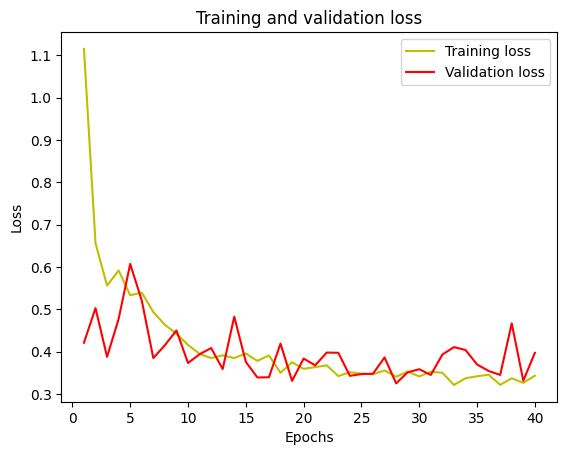

In [ ]:
history_visualization(aug_model_history)

Оценим модель с лучшими параметрами на тестовой выборке.

In [ ]:
aug_model_loaded = keras.models.load_model(aug_model_checkpoint_filepath)

**Accuracy составила 0.82.**

In [ ]:
aug_model_loaded.evaluate(test_data)

4/4 [==============================] - 1s 112ms/step - loss: 0.3705 - accuracy: 0.8203


[0.3705163598060608, 0.8203125]

In [ ]:
get_evaluation(aug_model_loaded, test_data, test_path)

### Добавление слоёв

Добавим ещё несколько полносвязных слоёв в модель.

####Модель нейронной сети

В модель добавилось ещё два полносвязных слоя с функциями активации relu. Также было решено оставить агментацию, поскольку аугментация способствует предотвращению переобучения модели.

In [ ]:
# Определяем модель нейронной сети
new_model = keras.models.Sequential([
  # добавили аугментацию
  data_augmentation,
  tf.keras.layers.Flatten(input_shape=(256,256,3)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
# Файл для сохранения модели с лучшими параметрами
new_model_checkpoint_filepath = 'best_model_new'

In [ ]:
new_model.compile(
  optimizer = "RMSprop",
  loss = "binary_crossentropy",
  metrics = ["accuracy"]
)

new_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 flatten_5 (Flatten)         (None, 196608)            0         
                                                                 
 dense_15 (Dense)            (None, 128)               25165952  
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                

In [ ]:
new_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath = new_model_checkpoint_filepath,
  monitor = 'val_accuracy',
  mode = 'max',
  save_best_only = True
)

####Обучение модели

Обучение производилось на 32 эпохах.

In [ ]:
# Тренировка модели
new_model_history = new_model.fit(
  train_data,
  batch_size = 1,
  verbose = 1,
  epochs = 32,
  validation_data = val_data,
  callbacks = [new_model_checkpoint_callback]
)

Epoch 1/32
64/64 [==============================] - 61s 929ms/step - loss: 11.9002 - accuracy: 0.5334 - val_loss: 2.8403 - val_accuracy: 0.5119
Epoch 2/32
64/64 [==============================] - 62s 965ms/step - loss: 2.3289 - accuracy: 0.5923 - val_loss: 0.9749 - val_accuracy: 0.6834
Epoch 3/32
64/64 [==============================] - 65s 1s/step - loss: 0.9639 - accuracy: 0.6482 - val_loss: 0.6975 - val_accuracy: 0.5409
Epoch 4/32
64/64 [==============================] - 59s 922ms/step - loss: 0.6266 - accuracy: 0.7135 - val_loss: 0.5355 - val_accuracy: 0.7414
Epoch 5/32
64/64 [==============================] - 59s 918ms/step - loss: 0.5788 - accuracy: 0.7323 - val_loss: 0.4266 - val_accuracy: 0.7968
Epoch 6/32
64/64 [==============================] - 59s 923ms/step - loss: 0.4927 - accuracy: 0.7793 - val_loss: 0.3787 - val_accuracy: 0.8074
Epoch 7/32
64/64 [==============================] - 59s 917ms/step - loss: 0.4726 - accuracy: 0.7798 - val_loss: 0.5321 - val_accuracy: 0.7916
E

####Оценка модели

Визуализация процесса обучения.

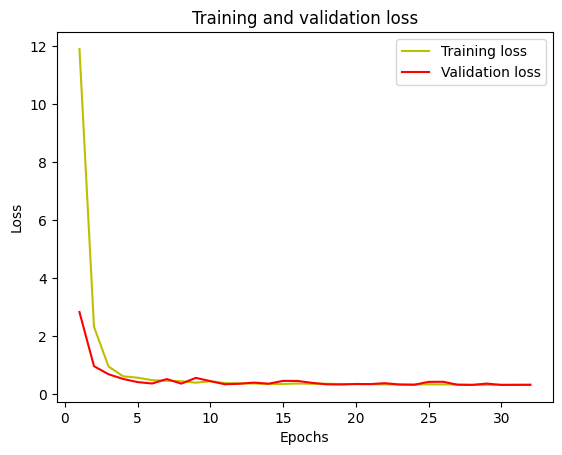

In [ ]:
history_visualization(new_model_history)

Загружаем модель из файла.

In [ ]:
new_model_loaded = keras.models.load_model(new_model_checkpoint_filepath)

Оцениваем на тестовой выборке.

**Точность составила 0.84.**

То есть столько же, сколько при обучении модели с тремя полносвязными слоями, без аугментации и оптимизатором RMSprop.

In [ ]:
new_model_loaded.evaluate(test_data)

4/4 [==============================] - 1s 108ms/step - loss: 0.3400 - accuracy: 0.8438


[0.3399651348590851, 0.84375]

In [ ]:
get_evaluation(new_model_loaded, test_data, test_path)

##Свёрточная модель

Слои:

*   Conv2D - реализация сверточного слоя в keras. Слой свёртки включает в себя для каждого канала свой фильтр, ядро свёртки которого обрабатывает предыдущий слой по фрагментам.
*   MaxPool2D - реализация операции max pooling. Следующий слой после сверточного должен укрупнять масштаб полученных признаков, для этого чаще всего используется операция MaxPooling (в каждом окне выбирается максимальное значение).







###Модель нейронной сети

Параметры в слоях Conv2D и MaxPool2D.

Conv2D:

filters - задает количество сверточных фильтров (каналов) в этом слое. Во время обучения сети фильтры обновляются таким образом, чтобы свести потери к минимуму. Таким образом, в ходе обучения фильтры научатся распознавать определенные элементы, такие как края и текстуры. Представляет собой целое число, размерность выходного пространства.

kernel_size - размер ядра каждого фильтра.

MaxPool2D

pool_size - размер окна, в котором выбирается максимальное значение.



In [ ]:
#Conv2D(filters, kernel_size, ...)

#MaxPool2D(pool_size, ...)



conv_model = Sequential([
    # добавим аугментацию данных
    data_augmentation,

    layers.Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPool2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Файл для сохранения модели с лучшими параметрами
conv_model_checkpoint_filepath = 'best_model_conv'

In [ ]:
conv_model.compile(
  optimizer = "RMSprop",
  loss = "binary_crossentropy",
  metrics = ["accuracy"]
)

conv_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 123008)           

In [ ]:
conv_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath = conv_model_checkpoint_filepath,
  monitor = 'val_accuracy',
  mode = 'max',
  save_best_only = True
)

###Обучение модели

In [ ]:
# Тренировка модели
conv_model_history = conv_model.fit(
  train_data,
  batch_size = 1,
  verbose = 1,
  epochs = 32,
  validation_data = val_data,
  callbacks = [conv_model_checkpoint_callback]
)

Epoch 1/32
64/64 [==============================] - 161s 2s/step - loss: 1.0283 - accuracy: 0.7373 - val_loss: 0.2828 - val_accuracy: 0.8839
Epoch 2/32
64/64 [==============================] - 158s 2s/step - loss: 0.2925 - accuracy: 0.8862 - val_loss: 0.2170 - val_accuracy: 0.9208
Epoch 3/32
64/64 [==============================] - 163s 3s/step - loss: 0.2540 - accuracy: 0.9075 - val_loss: 0.4526 - val_accuracy: 0.8021
Epoch 4/32
64/64 [==============================] - 156s 2s/step - loss: 0.2190 - accuracy: 0.9134 - val_loss: 0.1971 - val_accuracy: 0.9314
Epoch 5/32
64/64 [==============================] - 155s 2s/step - loss: 0.2053 - accuracy: 0.9248 - val_loss: 0.1676 - val_accuracy: 0.9340
Epoch 6/32
64/64 [==============================] - 153s 2s/step - loss: 0.1986 - accuracy: 0.9233 - val_loss: 0.1710 - val_accuracy: 0.9340
Epoch 7/32
64/64 [==============================] - 156s 2s/step - loss: 0.1877 - accuracy: 0.9317 - val_loss: 0.1588 - val_accuracy: 0.9340
Epoch 8/32
64

###Оценка модели

Визуализация процесса обучения. Переобучение наступает между 20 и 25 эпохами.

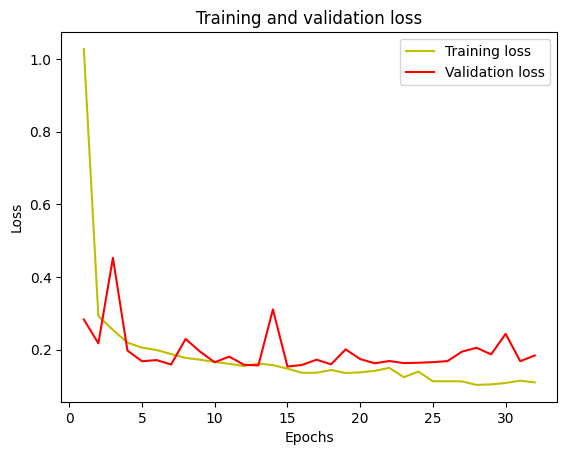

In [ ]:
history_visualization(conv_model_history)

Загружаем модель из файла.

In [ ]:
conv_model_loaded = keras.models.load_model(conv_model_checkpoint_filepath)

Оцениваем на тестовых данных.

**Accuracy составила 0.95 (самый высокий результат из всех моделей, как и ожидалось).**

In [ ]:
conv_model_loaded.evaluate(test_data)

4/4 [==============================] - 2s 564ms/step - loss: 0.1987 - accuracy: 0.9531


[0.19873428344726562, 0.953125]

In [ ]:
get_evaluation(conv_model_loaded, test_data, test_path)